In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Deep Learning for Time Series Forecasting
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [2]:
df = pd.read_csv('MicrosoftStock.csv')

In [3]:
df

,index,date,open,high,low,close,volume,Name
0,390198,2013-02-08,27.35,27.710,27.3100,27.55,33318306,MSFT
1,390199,2013-02-11,27.65,27.920,27.5000,27.86,32247549,MSFT
2,390200,2013-02-12,27.88,28.000,27.7500,27.88,35990829,MSFT
3,390201,2013-02-13,27.93,28.110,27.8800,28.03,41715530,MSFT
4,390202,2013-02-14,27.92,28.060,27.8700,28.04,32663174,MSFT
...,...,...,...,...,...,...,...,...
1254,391452,2018-02-01,94.79,96.070,93.5813,94.26,47227882,MSFT
1255,391453,2018-02-02,93.64,93.970,91.5000,91.78,47867753,MSFT
1256,391454,2018-02-05,90.56,93.240,88.0000,88.00,51031465,MSFT
1257,391455,2018-02-06,86.89,91.475,85.2500,91.33,67998564,MSFT


In [4]:
df.isnull().sum()

index     0
date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1259 non-null   int64  
 1   date    1259 non-null   object 
 2   open    1259 non-null   float64
 3   high    1259 non-null   float64
 4   low     1259 non-null   float64
 5   close   1259 non-null   float64
 6   volume  1259 non-null   int64  
 7   Name    1259 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 78.8+ KB


In [6]:
df.describe()

,index,open,high,low,close,volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,390827.000000,51.026394,51.436007,50.630397,51.063081,3.386946e+07
std,363.586303,14.859387,14.930144,14.774630,14.852117,1.958979e+07
min,390198.000000,27.350000,27.600000,27.230000,27.370000,7.425603e+06
25%,390512.500000,40.305000,40.637500,39.870000,40.310000,2.254879e+07
50%,390827.000000,47.440000,47.810000,47.005000,47.520000,2.938758e+07
75%,391141.500000,59.955000,60.435000,59.275000,59.730000,3.842024e+07
max,391456.000000,95.140000,96.070000,93.720000,95.010000,2.483542e+08


###  Data Preprocessing

In [7]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [8]:
from sklearn.preprocessing import MinMaxScaler

numeric_df = df.select_dtypes(include=['float64', 'int64'])

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(numeric_df)

# Step 3: Create a scaled DataFrame (with original index)
df_scaled = pd.DataFrame(scaled_data, columns=numeric_df.columns, index=df.index)

In [9]:
# Example: Calculate 10-day Simple Moving Average on closing price
df_scaled['SMA_10'] = df_scaled['close'].rolling(window=10).mean()

# Example: Calculate 10-day Exponential Moving Average
df_scaled['EMA_10'] = df_scaled['close'].ewm(span=10, adjust=False).mean()


In [10]:
rolling_mean = df_scaled['close'].rolling(window=20).mean()
rolling_std = df_scaled['close'].rolling(window=20).std()
df_scaled['Bollinger_Upper'] = rolling_mean + (2 * rolling_std)
df_scaled['Bollinger_Lower'] = rolling_mean - (2 * rolling_std)


In [11]:
# RSI
delta = df_scaled['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df_scaled['RSI'] = 100 - (100 / (1 + rs))


In [12]:
# Splitting
df_scaled.dropna(inplace=True)

# Determine split index
split_index = int(len(df_scaled) * 0.8)

# Split into training and testing
train_data = df_scaled[:split_index]
test_data = df_scaled[split_index:]

print(f"Train size: {train_data.shape}")
print(f"Test size: {test_data.shape}")

Train size: (992, 11)
Test size: (248, 11)


### EDA

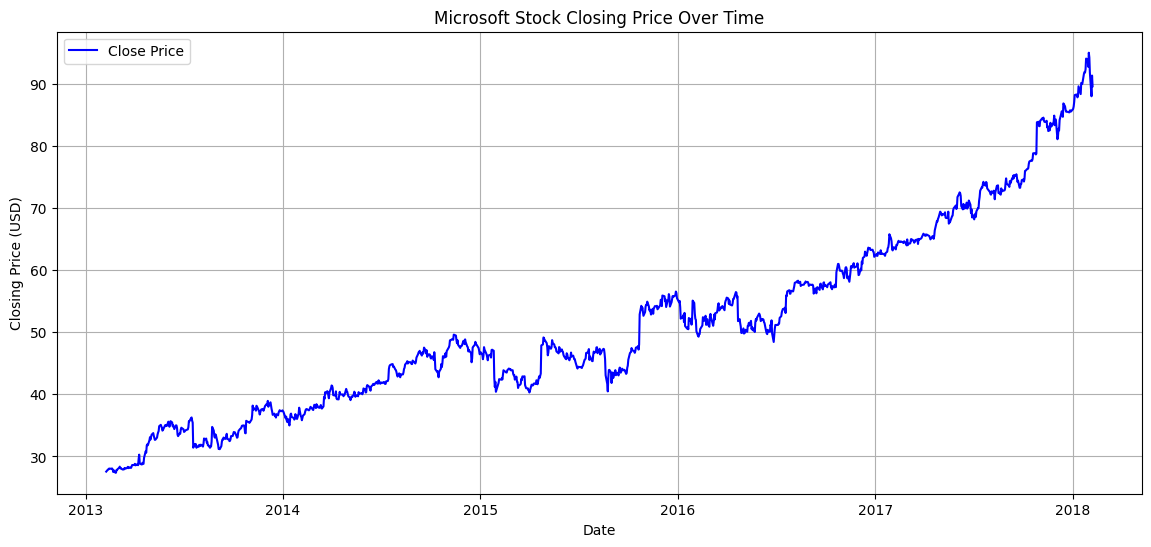

In [13]:
# plotting Charts
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Close Price', color='blue')
plt.title('Microsoft Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

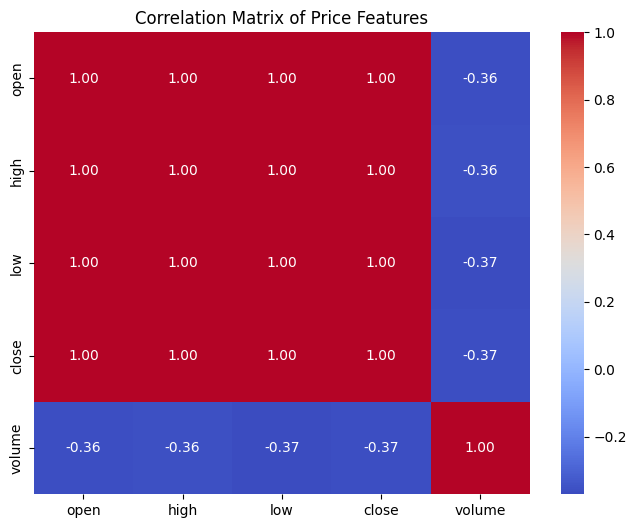

In [14]:
# Compute correlation heatmap
correlation_matrix = df[['open', 'high', 'low', 'close', 'volume']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Price Features')
plt.show()

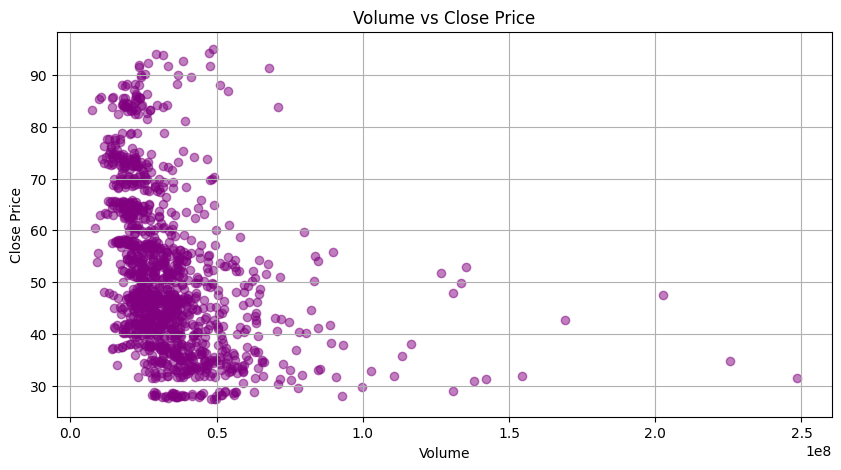

In [15]:
# Volume vs Price Scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(df['volume'], df['close'], alpha=0.5, color='purple')
plt.title('Volume vs Close Price')
plt.xlabel('Volume')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

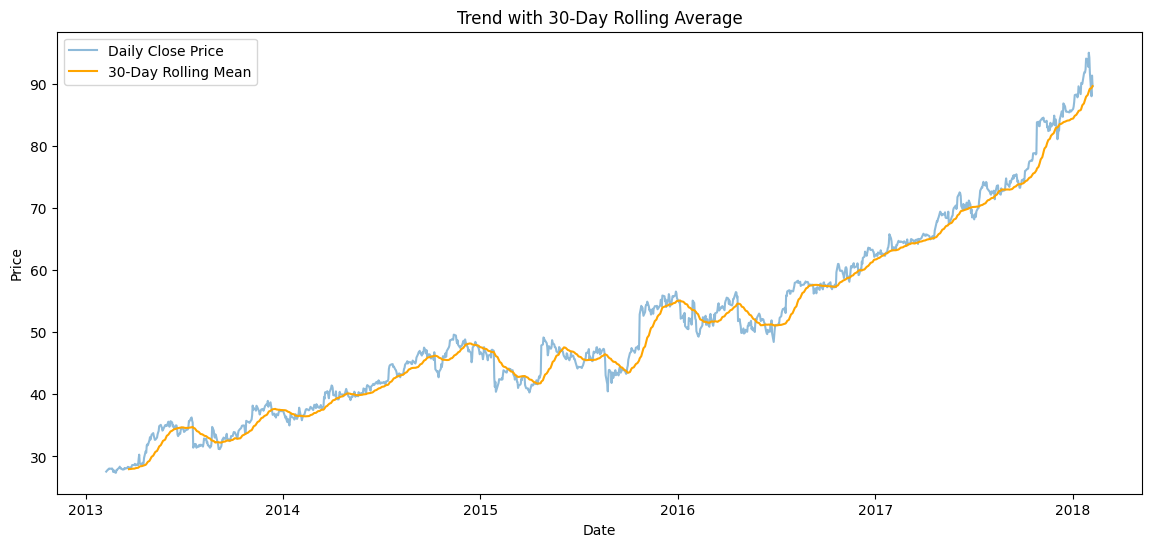

In [16]:
# Rolling Average
df['Rolling_Mean_30'] = df['close'].rolling(window=30).mean()

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['close'], label='Daily Close Price', alpha=0.5)
plt.plot(df.index, df['Rolling_Mean_30'], label='30-Day Rolling Mean', color='orange')
plt.title('Trend with 30-Day Rolling Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Model Training And Selection

In [17]:
# Define features and target
X = df_scaled.drop(columns=['close'])
y = df_scaled['close']

# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

### linear Regression Model

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Linear Regression")
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R² Score:", r2_score(y_test, y_pred_lr))

Linear Regression
MAE: 0.0029729665751744815
RMSE: 0.004738146329152141
R² Score: 0.9984834320609433


### Random forest

In [19]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R² Score:", r2_score(y_test, y_pred_rf))

Random Forest
MAE: 0.1464222174796362
RMSE: 0.1892882252143666
R² Score: -1.4204277925987543


### XgBoost 

In [20]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost")
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("R² Score:", r2_score(y_test, y_pred_xgb))

XGBoost
MAE: 0.1519165717133414
RMSE: 0.19329988112230156
R² Score: -1.5241090063266842


### LSTM Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Reshape for LSTM: [samples, time_steps, features]
X_lstm = df_scaled.drop(columns=['close']).values
y_lstm = df_scaled['close'].values

time_steps = 60

X_lstm_seq, y_lstm_seq = [], []
for i in range(time_steps, len(X_lstm)):
    X_lstm_seq.append(X_lstm[i-time_steps:i])
    y_lstm_seq.append(y_lstm[i])

X_lstm_seq = np.array(X_lstm_seq)
y_lstm_seq = np.array(y_lstm_seq)

# Train-test split for LSTM
split = int(0.8 * len(X_lstm_seq))
X_train_lstm, X_test_lstm = X_lstm_seq[:split], X_lstm_seq[split:]
y_train_lstm, y_test_lstm = y_lstm_seq[:split], y_lstm_seq[split:]

# Build the model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, verbose=1)

# Prediction
y_pred_lstm = model.predict(X_test_lstm)

print("LSTM Evaluation")
print("MAE:", mean_absolute_error(y_test_lstm, y_pred_lstm))
print("RMSE:", np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm)))

C:\Users\Ankit Sharma\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0431
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0162
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0153
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0095
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0016
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 7.8448e-04
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 9.9785e-04
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 5.4482e-04
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4.0642e-04
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 4.4807e-04
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
LSTM Evaluation
MAE: 0.11855996792096862
RMSE: 0.14026929390339798


## Model Evaluation And Prediction

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(name, y_true, y_pred):
    print(f"📌 {name}")
    print("MAE :", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R²   :", r2_score(y_true, y_pred))
    print("-" * 30)

# For classical models
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("XGBoost", y_test, y_pred_xgb)

# For LSTM
evaluate_model("LSTM", y_test_lstm, y_pred_lstm.flatten())

📌 Linear Regression
MAE : 0.0029729665751744815
RMSE: 0.004738146329152141
R²   : 0.9984834320609433
------------------------------
📌 Random Forest
MAE : 0.1464222174796362
RMSE: 0.1892882252143666
R²   : -1.4204277925987543
------------------------------
📌 XGBoost
MAE : 0.1519165717133414
RMSE: 0.19329988112230156
R²   : -1.5241090063266842
------------------------------
📌 LSTM
MAE : 0.11855996792096862
RMSE: 0.14026929390339798
R²   : -0.37786059057244437
------------------------------


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [24]:
# Fetch last 5 years of MSFT data
data = yf.download('MSFT', start='2020-01-01', end='2025-05-30')

# Use only 'Close' prices
df1 = data[['Close']].copy()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [25]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df1)

# Create sequences
sequence_length = 60  # days
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i])

X, y = np.array(X), np.array(y)

In [26]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, batch_size=32, epochs=10)

C:\Users\Ankit Sharma\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0667
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0046
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0044
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0039
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0033
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0032
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0030
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0028
Epoch 10/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0026


In [27]:
# Start with last 60 days from dataset
last_sequence = scaled_data[-sequence_length:]
predicted_prices = []

for _ in range(30):
    current_input = last_sequence.reshape(1, sequence_length, 1)
    pred = model.predict(current_input)[0][0]
    predicted_prices.append(pred)

    # Update the sequence
    last_sequence = np.append(last_sequence[1:], [[pred]], axis=0)

# Inverse transform to original prices
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

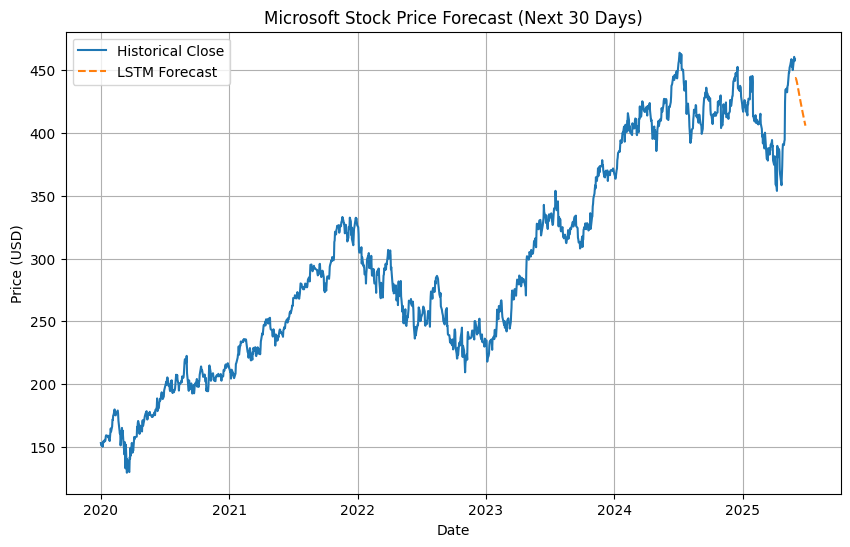

In [31]:
future_dates = pd.date_range(df1.index[-1] + pd.Timedelta(days=1), periods=30)
forecast_df = pd.DataFrame(predicted_prices, index=future_dates, columns=['Predicted_Close'])

plt.figure(figsize=(10, 6))
plt.plot(df1['Close'], label='Historical Close')
plt.plot(forecast_df['Predicted_Close'], label='LSTM Forecast', linestyle='--')
plt.title('Microsoft Stock Price Forecast (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()